Flow:
  1. Install & imports
  2. Load + tidy data (timestamp, index, frequency, NAs)
  3. Quick EDA: trend/seasonality; ACF/PACF to spot cycles
  4. Build Darts TimeSeries + time encoders + scaling
  5. Train TSMixer (why: mixes across time and features efficiently)
  6. Rolling backtest with historical_forecasts (honest evaluation)
  7. Random search tuning, refit best, forecast, plot
  8. Notes on adding *Christmas* seasonal regressors (commented how‑to)


# Libraries & Data

In [ ]:
# Install the darts library (time series models incl. TSMixer)
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Change to your working directory inside Drive
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Google TS Mixer

/content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series /Google TS Mixer


In [ ]:
# Core libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler

# Darts: TimeSeries container, scalers, and the Google TSMixer model
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TSMixerModel

In [ ]:
# Load bike share data
# Assumes columns: Date (yyyy-mm-dd), Hour (0..23), Total Users, plus exogenous fields
# We will create a proper hourly timestamp and set it as index
data = pd.read_csv('bike data.csv')
data.head()

,Date,Season,Hour,Holiday,Day of the Week,Working Day,Weather Type,Temperature F,Temperature Feels F,Humidity,Wind Speed,Casual Users,Registered Users,Total Users
0,1/1/2011,4,0,0,6,0,1,36.6,37.4,81,0,3,13,16
1,1/1/2011,4,1,0,6,0,1,34.9,35.6,80,0,8,32,40
2,1/1/2011,4,2,0,6,0,1,34.9,35.6,80,0,5,27,32
3,1/1/2011,4,3,0,6,0,1,36.6,37.4,75,0,3,10,13
4,1/1/2011,4,4,0,6,0,1,36.6,37.4,75,0,0,1,1


In [ ]:
# Create a single datetime column 'ds' combining calendar date + hour offset
# Continuous hourly index is critical for time‑based models and resampling
data['ds'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['Hour'], unit='h')
data.head()

,Date,Season,Hour,Holiday,Day of the Week,Working Day,Weather Type,Temperature F,Temperature Feels F,Humidity,Wind Speed,Casual Users,Registered Users,Total Users,ds
0,1/1/2011,4,0,0,6,0,1,36.6,37.4,81,0,3,13,16,2011-01-01 00:00:00
1,1/1/2011,4,1,0,6,0,1,34.9,35.6,80,0,8,32,40,2011-01-01 01:00:00
2,1/1/2011,4,2,0,6,0,1,34.9,35.6,80,0,5,27,32,2011-01-01 02:00:00
3,1/1/2011,4,3,0,6,0,1,36.6,37.4,75,0,3,10,13,2011-01-01 03:00:00
4,1/1/2011,4,4,0,6,0,1,36.6,37.4,75,0,0,1,1,2011-01-01 04:00:00


In [ ]:
# Rename target to the conventional 'y' for clarity in plots/models
data.rename(columns={'Total Users': 'y'}, inplace=True)

In [ ]:
# Drop unused columns to keep the design matrix lean (the model will see remaining columns as covariates)
# Tip: fewer, relevant signals = faster training and often better generalization
data.drop(columns=['Date', 'Season', 'Hour', 'Casual Users', 'Registered Users', 'Day of the Week', 'Temperature Feels F'], inplace=True)

In [ ]:
# Promote 'ds' to the DatetimeIndex
data.set_index('ds', inplace=True)

# Cast to hourly frequency; missing hours become NaN and will be handled next
df = data.asfreq('h')

In [ ]:
# Quick NA audit — gaps are common in operational data; we’ll forward‑fill safely
df.isnull().sum()

,0
Holiday,165
Working Day,165
Weather Type,165
Temperature F,165
Humidity,165
Wind Speed,165
y,165


In [ ]:
# Inspect which rows have any missing values (good for sanity‑checking data quality)
df[df.isnull().any(axis=1)]

,Holiday,Working Day,Weather Type,Temperature F,Humidity,Wind Speed,y
ds,,,,,,,
2011-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2012-10-30 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-08 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-29 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Fill missing values via forward fill (ffill)
# Why: keeps continuity without leaking future info; works for short gaps in weather/calendar regressors
# Note: for long gaps, prefer model‑based imputation
df.ffill(inplace=True)
df.head()

,Holiday,Working Day,Weather Type,Temperature F,Humidity,Wind Speed,y
ds,,,,,,,
2011-01-01 00:00:00,0.0,0.0,1.0,36.6,81.0,0.0,16.0
2011-01-01 01:00:00,0.0,0.0,1.0,34.9,80.0,0.0,40.0
2011-01-01 02:00:00,0.0,0.0,1.0,34.9,80.0,0.0,32.0
2011-01-01 03:00:00,0.0,0.0,1.0,36.6,75.0,0.0,13.0
2011-01-01 04:00:00,0.0,0.0,1.0,36.6,75.0,0.0,1.0


# Exploratory Data Analysis

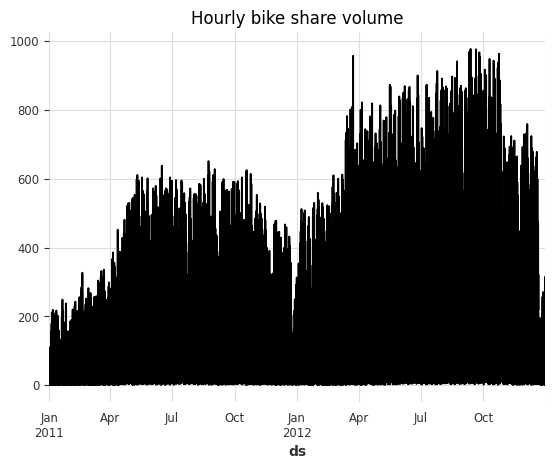

In [ ]:
# Raw plot — look for trend shifts, outliers, weekly cycles
df['y'].plot(title='Hourly bike share volume')
plt.show()

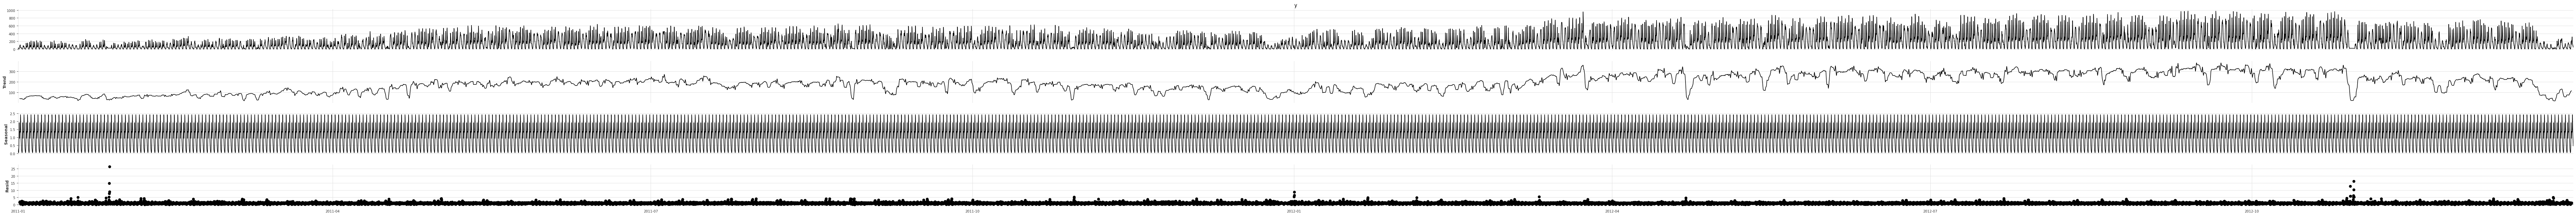

In [ ]:
# Seasonal decomposition (multiplicative): y ≈ trend × seasonal × residual
# With hourly data, period=24 reveals daily rhythm (commute peaks etc.)
decomposition = seasonal_decompose(df['y'], model='mul', period=24)
fig = decomposition.plot()
fig.set_size_inches(100, 8)  # wide figure for visibility in Colab
plt.show()

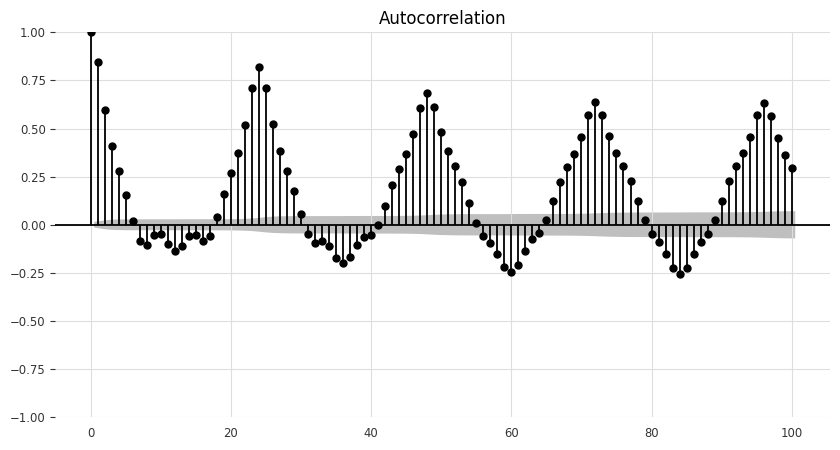

In [ ]:
# ACF — autocorrelation at different lags
# Spikes near 24, 48, 72 → daily seasonality; 168 → weekly
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df['y'], lags=100, ax=ax)
plt.show()

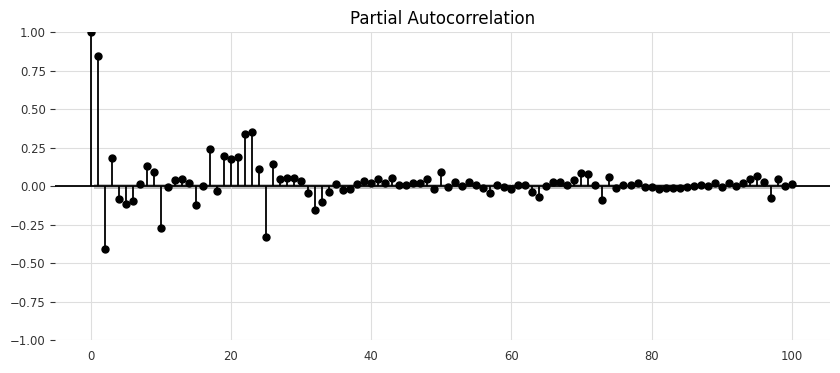

In [ ]:
# PACF — direct correlation at lags after removing intermediate effects
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df['y'], lags=100, ax=ax)
plt.show()

# Data Preparation

In [ ]:
# Prepare a TimeSeries object from the dataframe with Hourly frequency
series = TimeSeries.from_dataframe(df,
                                   value_cols = 'y',
                                   freq = 'H')
series

<TimeSeries (ds: 17544, component: 1, sample: 1)> Size: 140kB
array([[[16.]],

       [[40.]],

       [[32.]],

       ...,

       [[90.]],

       [[61.]],

       [[49.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 140kB 2011-01-01 ... 2012-12-31T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
# Simple year encoder (scaled); custom functions can inject domain knowledge
def encode_year(idx):
  return (idx.year - 2000) / 50

# Time encoders
# * cyclic: sine/cosine for hour/day/week/month (captures periodicity)
# * datetime_attribute: direct numeric attributes (e.g., hour)
# * position: relative position inside the input window (helps sequence models)
# * custom: our year encoder
# * transformer: scale encoders for stable training
# * tz: set timezone for correct calendar features
add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'CET'
}

In [ ]:
# Past covariates: all columns except the target become explanatory signals known up to the present
# Examples: weather, holidays, promotions — anything observed at or before t
X_past = df.iloc[:, :-1]
past_covariates = TimeSeries.from_dataframe(X_past, freq='H')
past_covariates

<TimeSeries (ds: 17544, component: 6, sample: 1)> Size: 842kB
array([[[ 0. ],
        [ 0. ],
        [ 1. ],
        [36.6],
        [81. ],
        [ 0. ]],

       [[ 0. ],
        [ 0. ],
        [ 1. ],
        [34.9],
        [80. ],
        [ 0. ]],

       [[ 0. ],
        [ 0. ],
        [ 1. ],
        [34.9],
        [80. ],
        [ 0. ]],
...
       [[ 0. ],
        [ 1. ],
        [ 1. ],
        [38.3],
        [60. ],
        [11. ]],

       [[ 0. ],
        [ 1. ],
        [ 1. ],
        [38.3],
        [56. ],
        [ 9. ]],

       [[ 0. ],
        [ 1. ],
        [ 1. ],
        [38.3],
        [65. ],
        [ 9. ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 140kB 2011-01-01 ... 2012-12-31T23:00:00
  * component  (component) object 48B 'Holiday' 'Working Day' ... 'Wind Speed'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
# Scale target and covariates — neural nets train faster and stabler when inputs are normalized
scaler1 = Scaler()
scaler2 = Scaler()

# Apply the scaler1 to the time series
series_scaled = scaler1.fit_transform(series)
past_covariates_scaled = scaler2.fit_transform(past_covariates)

# Google TSMixer

What is TSMixer (in simple words)?
* A lightweight architecture that "mixes" information **across time** and **across features** using MLP blocks.
* Temporal mixing: learns patterns over the look‑back window (like daily/weekly rhythms).
* Feature mixing: learns interactions between covariates and the target.
* Benefits: fast to train, strong for multivariate forecasting, fewer inductive biases than CNN/RNN.
Key knobs you set below:
* input_chunk_length (history window the model sees each sample)
* output_chunk_length (how many steps it predicts per pass — our horizon)
* hidden_size, ff_size (capacity of mixing layers)
* num_blocks (depth), dropout (regularization), n_epochs (training passes)


https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tsmixer_model.html?highlight=tsmixer#module-darts.models.forecasting.tsmixer_model

In [ ]:
# Set the forecasting horizon
forecasting_horizon = 24

In [ ]:
# Model definition (kept exactly as you wrote it)
model = TSMixerModel(
    input_chunk_length = 36,
    output_chunk_length = forecasting_horizon,
    add_encoders = add_encoders,
    hidden_size = 64,
    ff_size = 64,
    num_blocks = 2,
    n_epochs = 10,
    dropout = 0.1,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0]}
)
# Fit on scaled target with scaled past covariates
model.fit(series_scaled, past_covariates = past_covariates_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       |

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TSMixerModel(output_chunk_shift=0, hidden_size=64, ff_size=64, num_blocks=2, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, input_chunk_length=36, output_chunk_length=24, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7b6ac5d52200>], 'future': [<function encode_year at 0x7b6ac5d52200>]}, 'transformer': Scaler, 'tz': 'CET'}, n_epochs=10, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

# Cross-validation

In [ ]:
# historical_forecasts does a rolling-origin backtest:
# Start near the end, repeatedly predict the next 24h, advance by 24h, retrain each time (as configured).
# This mimics real use where future covariates are known and we predict the immediate horizon.
df.shape[0] - 5 * forecasting_horizon

17424

In [ ]:
# Define the CV configs
cv = model.historical_forecasts(
    series = series_scaled,
    past_covariates = past_covariates_scaled,
    forecast_horizon = forecasting_horizon,
    retrain = True,
    verbose = True,
    start = df.shape[0] - 5 * forecasting_horizon,
    stride = forecasting_horizon,
    last_points_only = False
)

historical forecasts:   0%|          | 0/5 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 888    | train
6 | feature_mixing_hist   | _FeatureMixing   | 10.7 K | train
7

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 1/5 [00:49<03:16, 49.24s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 888    | train
6 | feature_mixing_hist   | _FeatureMixing   | 10.7 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 2/5 [01:38<02:27, 49.04s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 888    | train
6 | feature_mixing_hist   | _FeatureMixing   | 10.7 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 3/5 [02:27<01:38, 49.01s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 888    | train
6 | feature_mixing_hist   | _FeatureMixing   | 10.7 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 4/5 [03:16<00:49, 49.03s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 888    | train
6 | feature_mixing_hist   | _FeatureMixing   | 10.7 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 5/5 [04:05<00:00, 49.07s/it]


In [ ]:
range(len(cv))

range(0, 5)

In [ ]:
rmse_cv = []

for i in range(len(cv)):
  # Measure the RMSE of the CV
  predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

  # Retrieve the actuals
  start = predictions.index.min()
  end = predictions.index.max()
  actuals = df.y[start:end]

  # Calculate the RMSE
  rmse = root_mean_squared_error(actuals, predictions)
  rmse_cv.append(rmse)

# Display the average rmse and rmse individual
print(f'Average RMSE: {np.mean(rmse_cv)}')
print(f'RMSE individual: {rmse_cv}')

Average RMSE: 61.34675336596526
RMSE individual: [16.660835715871684, 64.03088221749987, 105.01233955137111, 26.095392588156216, 94.93431675692744]


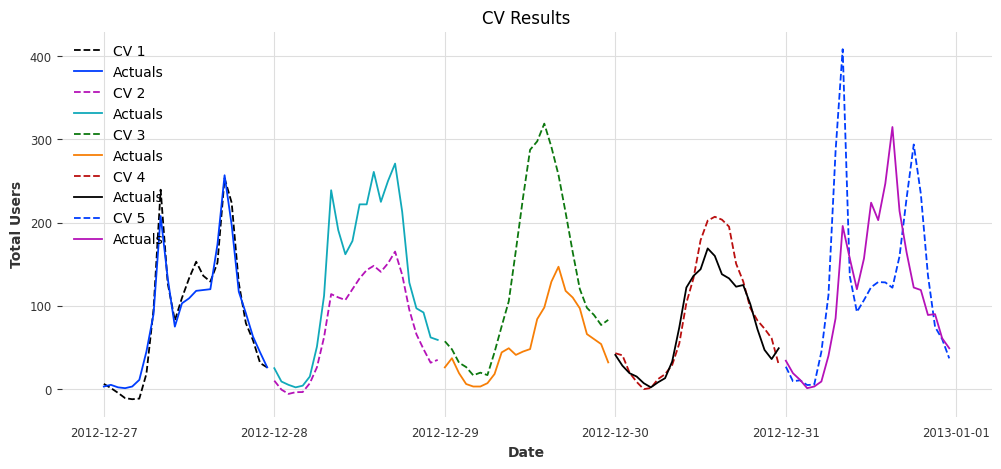

In [ ]:
# Visualize the CV and Actuals
fig, ax = plt.subplots(figsize = (12,5))

for i in range(len(cv)):
  # Measure the RMSE of the CV
  predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

  # Retrieve the actuals
  start = predictions.index.min()
  end = predictions.index.max()
  actuals = df.y[start:end]

  # Plot the predictions and actuals
  ax.plot(predictions, label = f'CV {i+1}', linestyle = "dashed")
  ax.plot(actuals, label = 'Actuals')

# Set the legend, xlabel, ylabel, and title
ax.legend()
ax.set_title("CV Results")
ax.set_xlabel("Date")
ax.set_ylabel("Total Users")

plt.show()

# Parameter Tuning

We’ll sample a few combos at random (ParameterSampler) to balance time vs. search coverage.
Tip: widen ranges first, then tighten around the best region in a second round.


In [ ]:
# Define the Parameter grid
param_grid = {
    'hidden_size': [32, 64, 96],
    'ff_size': [32, 64, 96],
    'num_blocks': [1,2,3],
    'input_chunk_length': [24, 36, 48],
    'dropout': [0.05, 0.1, 0.15],
    'n_epochs': [5,10, 20]
}

In [ ]:
# number of ramdom combinations to try
n_iter = 5

# Generate a list of random parameter combinations
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state = 1502))
param_list

[{'num_blocks': 2,
  'n_epochs': 20,
  'input_chunk_length': 24,
  'hidden_size': 96,
  'ff_size': 96,
  'dropout': 0.1},
 {'num_blocks': 1,
  'n_epochs': 20,
  'input_chunk_length': 24,
  'hidden_size': 64,
  'ff_size': 64,
  'dropout': 0.05},
 {'num_blocks': 2,
  'n_epochs': 10,
  'input_chunk_length': 48,
  'hidden_size': 64,
  'ff_size': 32,
  'dropout': 0.05},
 {'num_blocks': 1,
  'n_epochs': 10,
  'input_chunk_length': 36,
  'hidden_size': 64,
  'ff_size': 96,
  'dropout': 0.1},
 {'num_blocks': 3,
  'n_epochs': 20,
  'input_chunk_length': 48,
  'hidden_size': 64,
  'ff_size': 64,
  'dropout': 0.15}]

In [ ]:
# Define the fixed params
fixed_params = {
    'output_chunk_length': forecasting_horizon,
    'add_encoders': add_encoders,
    'pl_trainer_kwargs': {"accelerator": "gpu", "devices": [0]}
}

# Update each param list entry
for params in param_list:
  params.update(fixed_params)

In [ ]:
# Define an empty rmse list
rmse_list = []

for params in param_list:
  # Build the TSMixer model
  model = TSMixerModel(**params)

  # Perform Cross-validation
  cv = model.historical_forecasts(
      series = series_scaled,
      past_covariates = past_covariates_scaled,
      forecast_horizon = forecasting_horizon,
      retrain = True,
      verbose = True,
      start = df.shape[0] - 5 * forecasting_horizon,
      stride = forecasting_horizon,
      last_points_only = False
  )

  # Find the rmse of the cv fold
  rmse_cv = []
  for i in range(len(cv)):
    # Measure the RMSE of the CV
    predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

    # Retrive the actuals values
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.y[start:end]

    # Calculate the RMSE
    rmse = root_mean_squared_error(actuals, predictions)
    rmse_cv.append(rmse)

  # Find the average rmse
  avg_rmse = np.mean(rmse_cv)
  rmse_list.append(avg_rmse)


historical forecasts:   0%|          | 0/5 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 600    | train
6 | feature_mixing_hist   | _FeatureMixing   | 19.1 K | train


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2045.00it/s]

historical forecasts:  20%|██        | 1/5 [01:40<06:43, 100.90s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2012.62it/s]

historical forecasts:  40%|████      | 2/5 [03:21<05:02, 100.68s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2085.68it/s]

historical forecasts:  60%|██████    | 3/5 [05:01<03:20, 100.38s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1889.33it/s]

historical forecasts:  80%|████████  | 4/5 [06:41<01:40, 100.22s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1973.79it/s]

historical forecasts: 100%|██████████| 5/5 [08:22<00:00, 100.48s/it]

historical forecasts:   0%|          | 0/5 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollectio

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1995.39it/s]

historical forecasts:  20%|██        | 1/5 [01:24<05:38, 84.51s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2030.16it/s]

historical forecasts:  40%|████      | 2/5 [02:49<04:14, 84.73s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2023.30it/s]

historical forecasts:  60%|██████    | 3/5 [04:14<02:49, 84.93s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2244.14it/s]

historical forecasts:  80%|████████  | 4/5 [05:39<01:24, 84.98s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2105.57it/s]

historical forecasts: 100%|██████████| 5/5 [07:04<00:00, 84.91s/it]

historical forecasts:   0%|          | 0/5 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2490.68it/s]

historical forecasts:  20%|██        | 1/5 [00:50<03:20, 50.14s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2150.93it/s]

historical forecasts:  40%|████      | 2/5 [01:40<02:30, 50.09s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1602.10it/s]

historical forecasts:  60%|██████    | 3/5 [02:30<01:40, 50.32s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2011.66it/s]

historical forecasts:  80%|████████  | 4/5 [03:21<00:50, 50.37s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2179.99it/s]

historical forecasts: 100%|██████████| 5/5 [04:11<00:00, 50.30s/it]

historical forecasts:   0%|          | 0/5 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1208.73it/s]

historical forecasts:  20%|██        | 1/5 [00:42<02:50, 42.56s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2300.77it/s]

historical forecasts:  40%|████      | 2/5 [01:25<02:07, 42.65s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1903.91it/s]

historical forecasts:  60%|██████    | 3/5 [02:07<01:25, 42.60s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2106.63it/s]

historical forecasts:  80%|████████  | 4/5 [02:50<00:42, 42.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2046.00it/s]

historical forecasts: 100%|██████████| 5/5 [03:33<00:00, 42.62s/it]

historical forecasts:   0%|          | 0/5 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1959.04it/s]

historical forecasts:  20%|██        | 1/5 [01:55<07:43, 115.79s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1950.84it/s]

historical forecasts:  40%|████      | 2/5 [03:51<05:46, 115.53s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 1873.29it/s]

historical forecasts:  60%|██████    | 3/5 [05:46<03:50, 115.46s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2263.52it/s]

historical forecasts:  80%|████████  | 4/5 [07:41<01:55, 115.22s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]



Generating TimeSeries: 100%|██████████| 1/1 [00:00<00:00, 2000.14it/s]

historical forecasts: 100%|██████████| 5/5 [09:36<00:00, 115.39s/it]


In [ ]:
# Check the results of the tuning
results = pd.DataFrame(param_list)
results['RMSE'] = rmse_list
results

,num_blocks,n_epochs,input_chunk_length,hidden_size,ff_size,dropout,output_chunk_length,add_encoders,pl_trainer_kwargs,RMSE
0,2,20,24,96,96,0.10,24,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",74.283207
1,1,20,24,64,64,0.05,24,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",85.940293
2,2,10,48,64,32,0.05,24,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",83.197694
3,1,10,36,64,96,0.10,24,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",45.833892
4,3,20,48,64,64,0.15,24,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",82.502038


In [ ]:
# Export the best params to a CSV
results.loc[results["RMSE"].idxmin()].to_csv("best_params_tsmixer.csv")

# Predicting the future

In [ ]:
# Import the best params
best_params = pd.read_csv('best_params_tsmixer.csv', index_col = 0)
best_params

,3
num_blocks,1
n_epochs,10
input_chunk_length,36
hidden_size,64
ff_size,96
dropout,0.1
output_chunk_length,24
add_encoders,"{'cyclic': {'future': ['hour', 'day', 'dayofwe..."
pl_trainer_kwargs,"{'accelerator': 'gpu', 'devices': [0]}"
RMSE,45.833891869845694


In [ ]:
# Isolate the parameters
hidden_size = int(best_params.loc['hidden_size'].values[0])
num_blocks = int(best_params.loc['num_blocks'].values[0])
ff_size = int(best_params.loc['ff_size'].values[0])
input_chunk_length = int(best_params.loc['input_chunk_length'].values[0])
dropout = float(best_params.loc['dropout'].values[0])
n_epochs = int(best_params.loc['n_epochs'].values[0])


In [ ]:
# Build the Tuned Model
tuned_model = TSMixerModel(
    input_chunk_length = input_chunk_length,
    output_chunk_length = forecasting_horizon,
    add_encoders = add_encoders,
    n_epochs = n_epochs,
    hidden_size=hidden_size,
    ff_size = ff_size,
    num_blocks = num_blocks,
    dropout = dropout,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0]}
)
tuned_model.fit(series_scaled, past_covariates = past_covariates_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 888    | train
6 | feature_mixing_hist   | _FeatureMixing   | 13.6 K | train
7 | feature_mixing_future | _FeatureMixing   | 12.2 K | trai

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TSMixerModel(output_chunk_shift=0, hidden_size=64, ff_size=96, num_blocks=1, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, input_chunk_length=36, output_chunk_length=24, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7b6ac5d52200>], 'future': [<function encode_year at 0x7b6ac5d52200>]}, 'transformer': Scaler, 'tz': 'CET'}, n_epochs=10, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
# Predict with the tuned model and transform into a pandas series
forecast = tuned_model.predict(n = forecasting_horizon,
                          past_covariates = past_covariates_scaled)
forecast = TimeSeries.to_series(scaler1.inverse_transform(forecast))
forecast

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,y
ds,
2013-01-01 00:00:00,48.655653
2013-01-01 01:00:00,21.909725
2013-01-01 02:00:00,18.593185
2013-01-01 03:00:00,10.025583
2013-01-01 04:00:00,14.375441
2013-01-01 05:00:00,51.421424
2013-01-01 06:00:00,203.743772
2013-01-01 07:00:00,355.736104
2013-01-01 08:00:00,586.559722


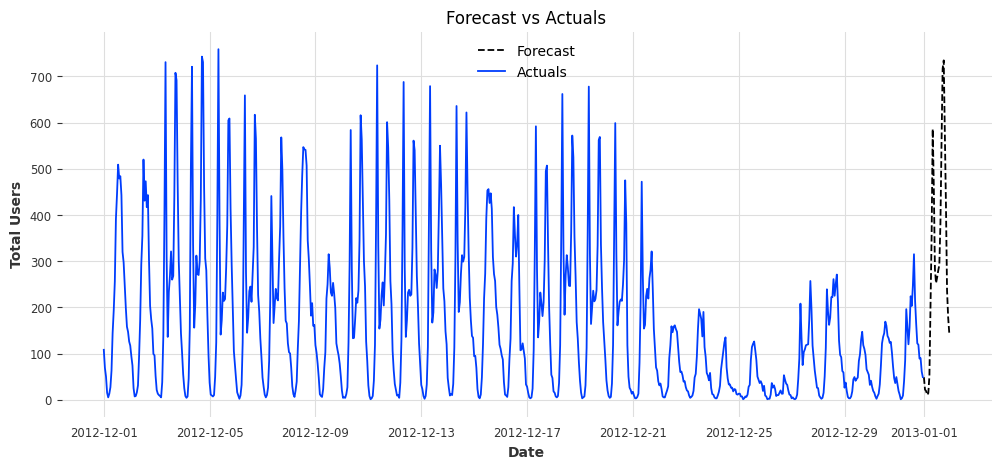

In [ ]:
# Visualize the predictions and training data
fig, ax = plt.subplots(figsize = (12,5))

# Plot the predictions and actuals
ax.plot(forecast, label = 'Forecast', linestyle = "dashed")
ax.plot(df.y['2012-12'], label = 'Actuals')

# Set the legend, xlabel, ylabel, and title
ax.legend()
ax.set_title("Forecast vs Actuals")
ax.set_xlabel("Date")
ax.set_ylabel("Total Users")
plt.show()